# Hate Speech Classification - Cute 4

In [2]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.utils.np_utils import to_categorical
from keras.layers.embeddings import Embedding

## Plotly

# import plotly.offline as py
# import plotly.graph_objs as go
# py.init_notebook_mode(connected=True)

# Others
import nltk
import string
import pandas as pd
from nltk.corpus import stopwords
import os
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE


%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## The dataset

In [72]:
df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

In [73]:
print(df.shape)
df.head()

(25307, 5)


,id,text,hate_speech,obscene,insulting
0,4255,"""\n\n""""Vandalising"""", """"Ok for the last time""""...",1,1,1
1,19037,Where you at devil? The World's Greatest Terro...,1,1,1
2,4552,Here I am: 0Waldo with my 'OTHER' response to ...,1,1,1
3,30048,well then don't \n\nundo other people's edits ...,0,0,0
4,9643,Mr. kMan \n\nhi. I dont like the tonne of your...,1,0,0


In [74]:
df[df.apply(lambda x: x['id'] in [1,27538,28,33, 10040,27162, 3522,9531], axis=1)]

,id,text,hate_speech,obscene,insulting
5,27162,it becomes the primary reason why the Internet...,0,1,0
33,27538,shut your hole sun of beach. nobody asked u tard,1,0,1
35,10040,fuck u i will do as i please,1,1,0
394,3522,"""\n\nDrmies your page looks like shit. I can't...",0,1,1
911,9531,Bold textThe many constructive editors of this...,0,0,1
6989,1,"""\n\nThanks\nThanks for reverting the vandalis...",0,0,0
11696,28,TT Quick \n\nPlease revert to TT Quick.net.......,1,1,1
15453,33,You are such an ignorant piece of refuse. You ...,1,0,0


In [11]:
df['text'][0]

'"\n\n""Vandalising"", ""Ok for the last time"" - who the fuck do you think are? Mr Encyclopaedia?\n\nYou don\'t own Wikipedia loser, you English ""twat"" (hey, why don\'t you contribute to the meaning of that one by describing yourself ??)\n\nGet a life"'

In [12]:
df['text'][3]

"well then don't \n\nundo other people's edits when you clearly don't know what you're talking about! you made a right cunt of that one mate!"

In [15]:
df['text'][4]

'Mr. kMan \n\nhi. I dont like the tonne of your face. Do you touch your mom with those fingers?'

In [14]:
df['text'][5]

'it becomes the primary reason why the Internet sucks.\n\nSo, wikifiddle, and wait when the party and its in reality sets in.'

In [52]:
print(test_df.shape)
test_df.head()

(6327, 2)


,id,text
0,21810,This robot \n\nIs WAY cooler than danski
1,5865,Gone through with a bit of a hedge trimmer app...
2,25859,Commissioner of Consumer Affairs \n\nCan someo...
3,8721,or any historical fact concerning current Arme...
4,8194,You might think that; I couldn't possibly comm...


## User defined Functions

In [3]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

# Function to encoding target
def createLable(row):
    if row['hate_speech'] == 0 and row['obscene'] ==  0 and row['insulting'] == 0:
        x = 0
    elif row['hate_speech'] == 0 and row['obscene'] ==  0 and row['insulting'] == 1:
        x = 1
    elif row['hate_speech'] == 0 and row['obscene'] ==  1 and row['insulting'] == 0:
        x = 2
    elif row['hate_speech'] == 0 and row['obscene'] ==  1 and row['insulting'] == 1:
        x = 3
    elif row['hate_speech'] == 1 and row['obscene'] ==  0 and row['insulting'] == 0:
        x = 4
    elif row['hate_speech'] == 1 and row['obscene'] ==  1 and row['insulting'] == 0:
        x = 5
    elif row['hate_speech'] == 1 and row['obscene'] ==  0 and row['insulting'] == 1:
        x = 6
    else:
        x = 7
    return x

########### hamming score##############

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

    print('Hamming score: {0}'.format(hamming_score(y_true, y_pred))) # 0.375 (= (0.5+1+0+0)/4)

    import sklearn.metrics
    print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)))
    print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_true, y_pred))) 

def hamming_score_step(pred, actual):
    result = pd.DataFrame({ 'target': pred,  'actual': actual})
    result['hate_speech'] = result.apply(lambda row: 1 if row['target'] in [4,5,6,7] else 0, axis=1 )
    result['obscene'] = result.apply(lambda row: 1 if row['target'] in [2,3,5,7] else 0, axis=1 )
    result['insulting'] = result.apply(lambda row: 1 if row['target'] in [1,3,6,7] else 0, axis=1 )
    result['hate_speech_A'] = result.apply(lambda row: 1 if row['actual'] in [4,5,6,7] else 0, axis=1 )
    result['obscene_A'] = result.apply(lambda row: 1 if row['actual'] in [2,3,5,7] else 0, axis=1 )
    result['insulting_A'] = result.apply(lambda row: 1 if row['actual'] in [1,3,6,7] else 0, axis=1 )
    print('Hamming score: {0}'.format(hamming_score(result[['hate_speech_A','obscene_A','insulting_A']].values, result[['hate_speech','obscene','insulting']].values))) # 0.375 (= (0.5+1+0+0)/4)

In [54]:
df['text'] = df['text'].map(lambda x: clean_text(x))
print(df.head())
test_df['text'] = test_df['text'].map(lambda x: clean_text(x)) ;
print(test_df.head())

      id                                               text  hate_speech  \
0   4255  + + vandalis ok last time fuck think are encyc...            1   
1  19037  devil world greatest terrorist forgot scum + +...            1   
2   4552  am : 0waldo other respons total collater blath...            1   
3  30048  well + + undo peopl edit clear know talk about...            0   
4   9643  mr kman + + hi dont like tonn face touch mom f...            1   

   obscene  insulting  
0        1          1  
1        1          1  
2        1          1  
3        0          0  
4        0          0  
      id                                               text
0  21810                     robot + + is way cooler danski
1   5865  gone bit hedg trimmer approach think remov any...
2  25859  commission consum affair + + can someon add se...
3   8721  histor fact concern current armenia pertain wi...
4   8194  might think that; possibl comment nice pars ac...


## Target Creation

In [75]:
df['target'] = df.apply(createLable, axis = 1)

In [76]:
df.head()

,id,text,hate_speech,obscene,insulting,target
0,4255,"""\n\n""""Vandalising"""", """"Ok for the last time""""...",1,1,1,7
1,19037,Where you at devil? The World's Greatest Terro...,1,1,1,7
2,4552,Here I am: 0Waldo with my 'OTHER' response to ...,1,1,1,7
3,30048,well then don't \n\nundo other people's edits ...,0,0,0,0
4,9643,Mr. kMan \n\nhi. I dont like the tonne of your...,1,0,0,4


In [77]:
df[df.apply(lambda x: x['id'] in [1,27538,28,33, 10040,27162, 3522,9531], axis=1)].sort_values('target')

,id,text,hate_speech,obscene,insulting,target
6989,1,"""\n\nThanks\nThanks for reverting the vandalis...",0,0,0,0
911,9531,Bold textThe many constructive editors of this...,0,0,1,1
5,27162,it becomes the primary reason why the Internet...,0,1,0,2
394,3522,"""\n\nDrmies your page looks like shit. I can't...",0,1,1,3
15453,33,You are such an ignorant piece of refuse. You ...,1,0,0,4
35,10040,fuck u i will do as i please,1,1,0,5
33,27538,shut your hole sun of beach. nobody asked u tard,1,0,1,6
11696,28,TT Quick \n\nPlease revert to TT Quick.net.......,1,1,1,7


In [78]:
df[df.apply(lambda x: x['id'] in [1,27538,28,33, 10040,27162, 3522,9531], axis=1)].sort_values('target').to_csv("sample.csv", index=False)

In [80]:
df[['id','target']].to_csv('target_coulmn.csv')

We will only consider the  text of the reviews and the target.

In [81]:
df['target'].value_counts()

0    12603
4     4801
7     4775
5     1590
6     1096
2      255
3      163
1       24
Name: target, dtype: int64

- 0 means comment is not  'hate_speech', 'obscene' and 'insulting'

- 1 means comment is only 'insulting'

- 2 means comment is only 'obscence'

- 3 means comment is 'obscene' and 'insulting'

- 4 means comment is 'hate_speech'

- 5 means comment is 'hate_speech' and 'obscene'

- 6 means comment is 'hate_speech' and 'insulting'

- 7 means comment is 'hate_speech', 'obscene' and 'insulting'

Text(0.9,5500,"0 - comment is not  'hate_speech', 'obscene' and 'insulting' \n 1 - comment is only 'insulting' \n 2 - comment is only 'obscence' \n 3 - comment is 'obscene' and 'insulting'\n4 - comment is 'hate_speech'\n5 - comment is 'hate_speech' and 'obscene'\n6 - comment is 'hate_speech' and 'insulting'\n7 - comment is 'hate_speech', 'obscene' and 'insulting'")

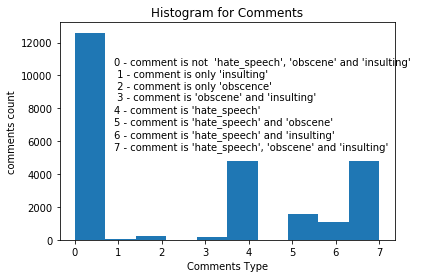

In [82]:
plt.hist(df['target'])
plt.xlabel('Comments Type')
plt.ylabel('comments count')
plt.title('Histogram for Comments')
# plt.grid(True)
plt.annotate("0 - comment is not  'hate_speech', 'obscene' and 'insulting' \n 1 - comment is only 'insulting' \n 2 - comment is only 'obscence' \n 3 - comment is 'obscene' and 'insulting'\n4 - comment is 'hate_speech'\n5 - comment is 'hate_speech' and 'obscene'\n6 - comment is 'hate_speech' and 'insulting'\n7 - comment is 'hate_speech', 'obscene' and 'insulting'",
             xy=(0.9, 5500))

In [83]:
df.groupby('target')['hate_speech'].count()/df['target'].count()

target
0    0.498005
1    0.000948
2    0.010076
3    0.006441
4    0.189710
5    0.062828
6    0.043308
7    0.188683
Name: hate_speech, dtype: float64

Train data has 49.8% has good comments and 50.2% has bad comments

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [84]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = df['text'].astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\text.py:174: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 59256 unique tokens.


In [85]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 59256)

In [86]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [87]:
" ".join([index_to_word[i] for i in sequences[0]])

"vandalising ok for the last time who the fuck do you think are mr encyclopaedia you don't own wikipedia loser you english twat hey why don't you contribute to the meaning of that one by describing yourself get a life"

In [88]:
index_to_word[46]


'just'


Let's have a closer look at the tokenized sequences:

In [89]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 59.8
max length: 1400


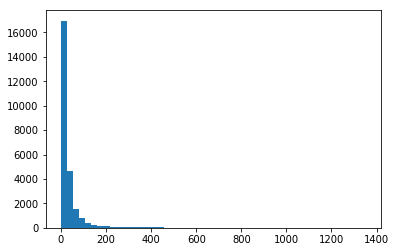

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);


Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 200 symbols:

Text(0.5,1,'Sequence Length Distribution')

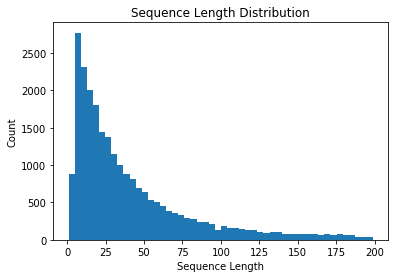

In [92]:
plt.hist([l for l in seq_lens if l < 200], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Sequence Length Distribution')

# Baseline Model

In [4]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [5]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [6]:
# load dataset
dataframe = pandas.read_csv("Train.csv")
print(dataframe.head())
dataframe_test = pd.read_csv("Test.csv")
dataframe['text'] = dataframe['text'].map(lambda x: clean_text(x))
print(dataframe.head())
dataframe_test['text'] = dataframe_test['text'].map(lambda x: clean_text(x))
dataframe['target'] = dataframe.apply(createLable, axis = 1)
print(dataframe.head())

      id                                               text  hate_speech  \
0   4255  "\n\n""Vandalising"", ""Ok for the last time""...            1   
1  19037  Where you at devil? The World's Greatest Terro...            1   
2   4552  Here I am: 0Waldo with my 'OTHER' response to ...            1   
3  30048  well then don't \n\nundo other people's edits ...            0   
4   9643  Mr. kMan \n\nhi. I dont like the tonne of your...            1   

   obscene  insulting  
0        1          1  
1        1          1  
2        1          1  
3        0          0  
4        0          0  
      id                                               text  hate_speech  \
0   4255  + + vandalis ok last time fuck think are encyc...            1   
1  19037  devil world greatest terrorist forgot scum + +...            1   
2   4552  am : 0waldo other respons total collater blath...            1   
3  30048  well + + undo peopl edit clear know talk about...            0   
4   9643  mr kman +

In [7]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = dataframe['text'].astype(str)
texts_test_msg = dataframe_test['text'].astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test_msg)

C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\text.py:174: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [8]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print(x_train)
x_test_msg = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)


Shape of data tensor: (25307, 150)
[[    0     0     0 ...   556    14   104]
 [    0     0     0 ...     1  4915  7241]
 [    0     0     0 ...  9885  1437  1775]
 ...
 [    0     0     0 ...     6   203   128]
 [    0     0     0 ...   188 11200    79]
 [    0     0     0 ...     0  1018   296]]


In [9]:
X = x_train
Y = dataframe['target']

In [10]:
Y[:5]

0    7
1    7
2    7
3    0
4    4
Name: target, dtype: int64

In [11]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(Y)

150 inputs -> [100 hidden nodes] -> 8 outputs

In [139]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(100, input_dim=150, activation='relu'))
	model.add(Dense(8, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [140]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)

In [141]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [142]:
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 49.60% (0.95%)


In [143]:
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size=0.33, random_state=seed)
estimator.fit(X_train, Y_train)
predictions = estimator.predict(X_test)
print(predictions)

[4 4 4 ... 4 4 0]


In [144]:
np.unique(predictions)
# print(encoder.inverse_transform(predictions))

array([0, 4, 7])

In [145]:
hamming_score_step(estimator.predict(X_test), Y_test.argmax(1))

Hamming score: 0.37158764367816094


In [57]:
final = estimator.predict(x_test_msg)
result = pd.DataFrame({'id': dataframe_test['id'], 'target': final})
result['hate_speech'] = result.apply(lambda row: 1 if row['target'] in [4,5,6,7] else 0, axis=1 )
result['obscene'] = result.apply(lambda row: 1 if row['target'] in [2,3,5,7] else 0, axis=1 )
result['insulting'] = result.apply(lambda row: 1 if row['target'] in [1,3,6,7] else 0, axis=1 )
result = result.drop('target', axis = 1)
result.head()

,id,hate_speech,obscene,insulting
0,21810,0,0,0
1,5865,0,0,0
2,25859,0,0,0
3,8721,0,0,0
4,8194,0,0,0


In [58]:
result.to_csv("result2.csv", index=False)

## A complex model : LSTM

150 inputs -> [Embedding 20000, 100] -> [100 hidden nodes LSTM] -> 8 outputs

In [146]:
from keras.models import Sequential
model = Sequential()
model.add(Embedding(20000, 100, input_length=150))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [147]:
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size=0.33, random_state=seed)


In [148]:
model.fit(X_train, Y_train, validation_split=0.4, epochs=8)

Train on 10173 samples, validate on 6782 samples
Epoch 1/8
10173/10173 [==============================] - 88s 9ms/step - loss: 1.0887 - acc: 0.6232 - val_loss: 0.8448 - val_acc: 0.7128
Epoch 2/8
10173/10173 [==============================] - 90s 9ms/step - loss: 0.6991 - acc: 0.7598 - val_loss: 0.7933 - val_acc: 0.7322
Epoch 3/8
10173/10173 [==============================] - 96s 9ms/step - loss: 0.5479 - acc: 0.8100 - val_loss: 0.8711 - val_acc: 0.7246
Epoch 4/8
10173/10173 [==============================] - 96s 9ms/step - loss: 0.4364 - acc: 0.8498 - val_loss: 0.8992 - val_acc: 0.7144
Epoch 5/8
10173/10173 [==============================] - 93s 9ms/step - loss: 0.3374 - acc: 0.8900 - val_loss: 1.0301 - val_acc: 0.7027
Epoch 6/8
10173/10173 [==============================] - 82s 8ms/step - loss: 0.2601 - acc: 0.9139 - val_loss: 1.1040 - val_acc: 0.6924
Epoch 7/8
10173/10173 [==============================] - 83s 8ms/step - loss: 0.2024 - acc: 0.9362 - val_loss: 1.2207 - val_acc: 0.6929

In [112]:
hamming_score_step(model.predict_classes(X_test), Y_test.argmax(1))

Hamming score: 0.7784562579821199


In [26]:
final =  model.predict_classes(x_test_msg)
result = pd.DataFrame({'id': dataframe_test['id'], 'target': final})
result['hate_speech'] = result.apply(lambda row: 1 if row['target'] in [4,5,6,7] else 0, axis=1 )
result['obscene'] = result.apply(lambda row: 1 if row['target'] in [2,3,5,7] else 0, axis=1 )
result['insulting'] = result.apply(lambda row: 1 if row['target'] in [1,3,6,7] else 0, axis=1 )
result = result.drop('target', axis = 1)
result.head()

,id,hate_speech,obscene,insulting
0,21810,0,0,0
1,5865,0,0,0
2,25859,0,0,0
3,8721,1,1,1
4,8194,0,0,0


In [64]:
result.to_csv("result3.csv", index=False)

In [28]:
len(X_test)

8352

In [113]:
from keras import backend as K
get_emb_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].input])
embedding_output = get_emb_layer_output([X_test[:3000]])[0]

In [114]:
emb_shape = embedding_output.shape
to_plot_embedding = embedding_output.reshape(emb_shape[0],emb_shape[1])
y = X_test[:3000]

In [115]:
sentence_emb_tsne = TSNE(perplexity=30).fit_transform(to_plot_embedding)

In [60]:
y.shape

(3000, 150)

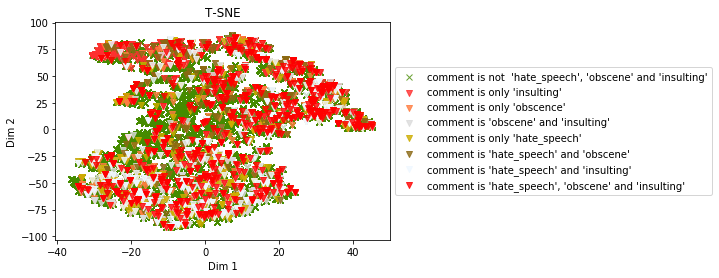

In [117]:
plt.figure()

plt.scatter(sentence_emb_tsne[np.where(y == 0), 0],
                   sentence_emb_tsne[np.where(y == 0), 1],
                   marker='x', color='#458B00', 
                   linewidth='1', alpha=0.8, label="comment is not  'hate_speech', 'obscene' and 'insulting'")
plt.scatter(sentence_emb_tsne[np.where(y == 1), 0],
                   sentence_emb_tsne[np.where(y == 1), 1],
                   marker='v', color='#FF3030',
                   linewidth='1', alpha=0.8, label="comment is only 'insulting'")
plt.scatter(sentence_emb_tsne[np.where(y == 2), 0],
                   sentence_emb_tsne[np.where(y == 2), 1],
                   marker='v', color='#FF7D40',
                   linewidth='1', alpha=0.8, label="comment is only 'obscence'")
plt.scatter(sentence_emb_tsne[np.where(y == 3), 0],
                   sentence_emb_tsne[np.where(y == 3), 1],
                   marker='v', color='#DCDCDC',
                   linewidth='1', alpha=0.8, label="comment is 'obscene' and 'insulting'")
plt.scatter(sentence_emb_tsne[np.where(y == 4), 0],
                   sentence_emb_tsne[np.where(y == 4), 1],
                   marker='v', color='#CDAD00',
                   linewidth='1', alpha=0.8, label="comment is only 'hate_speech'")
plt.scatter(sentence_emb_tsne[np.where(y == 5), 0],
                   sentence_emb_tsne[np.where(y == 5), 1],
                   marker='v', color='#8B6914',
                   linewidth='1', alpha=0.8, label="comment is 'hate_speech' and 'obscene'")
plt.scatter(sentence_emb_tsne[np.where(y == 6), 0],
                   sentence_emb_tsne[np.where(y == 6), 1],
                   marker='v', color='#F0F8FF',
                   linewidth='1', alpha=0.8, label="comment is 'hate_speech' and 'insulting'")				   
plt.scatter(sentence_emb_tsne[np.where(y == 7), 0],
                   sentence_emb_tsne[np.where(y == 7), 1],
                   marker='v', color='r',
                   linewidth='1', alpha=0.8, label="comment is 'hate_speech', 'obscene' and 'insulting'")

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('1.png')
plt.show()  

# Pre-Trained GloVe

In [20]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import GlobalMaxPool1D

In [119]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding="utf8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [120]:
MAX_SEQUENCE_LENGTH = 100

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print(x_train)
x_test_msg = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)


Shape of data tensor: (25307, 100)
[[    0     0     0 ...   556    14   104]
 [    0     0     0 ...     1  4915  7241]
 [  365  1655  3226 ...  9885  1437  1775]
 ...
 [    0     0     0 ...     6   203   128]
 [    0     0     0 ...   188 11200    79]
 [    0     0     0 ...     0  1018   296]]


In [121]:
len(tokenizer.word_index.items())

41814

In [122]:
# create a weight matrix for words in training docs
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [123]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, dummy_y, test_size=0.33, random_state=seed)

100 inputs -> [Embedding 20000, 100, weights=[embedding_matrix], input_length=100, trainable=False] -> [100 hidden nodes Dense] -> 8 outputs

In [124]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(8, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(X_train, Y_train, epochs=8, verbose=0)
# model.fit(X, Y, epochs=8, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(X_train, Y_train, verbose=0)
print('Accuracy: %f' % (accuracy*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          4181500   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1000100   
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 808       
Total params: 5,182,408
Trainable params: 1,000,908
Non-trainable params: 4,181,500
_________________________________________________________________
None
Accuracy: 98.554999


In [72]:
hamming_score_step(model.predict_classes(X_test), Y_test.argmax(1))

Hamming score: 0.49207774584929753


# lstm - cnn

100 inputs -> [Embedding 20000, 100, input_length=100] -> Dropout(0.2) -> Conv1D(64, 5, activation='relu') -> MaxPooling1D(pool_size=4) -> [100 hidden nodes LSTM] -> 8 outputs

In [125]:
model = Sequential()
# Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False)
model.add(Embedding(vocab_size, 100, input_length=100))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [126]:
print(model.summary())
# fit the model
model.fit(X_train, Y_train, epochs=8, verbose=0)
# model.fit(X, Y, epochs=8, verbose=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          4181500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 808       
Total params: 4,280,372
Trainable params: 4,280,372
Non-trainable params: 0
_________________________________________________________________


In [127]:
# evaluate the model
loss, accuracy = model.evaluate(X_train, Y_train, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 98.859481


In [128]:
hamming_score_step(model.predict_classes(X_test), Y_test.argmax(1))

Hamming score: 0.7891123882503193


In [129]:
final =  model.predict_classes(x_test_msg)
result = pd.DataFrame({'id': dataframe_test['id'], 'target': final})
result['hate_speech'] = result.apply(lambda row: 1 if row['target'] in [4,5,6,7] else 0, axis=1 )
result['obscene'] = result.apply(lambda row: 1 if row['target'] in [2,3,5,7] else 0, axis=1 )
result['insulting'] = result.apply(lambda row: 1 if row['target'] in [1,3,6,7] else 0, axis=1 )
result = result.drop('target', axis = 1)
result.head()

,id,hate_speech,obscene,insulting
0,21810,0,0,0
1,5865,0,0,0
2,25859,0,0,0
3,8721,1,1,1
4,8194,0,0,0


In [130]:
result.to_csv("result4.csv", index=False)

# CNN

100 inputs -> [Embedding 20000, 128, input_length=150] -> Conv1D(64, 5, activation='relu') -> GloballMaxPool1D() -> Dropout(0.2) -> [50 hidden nodes Dense] -> Dropout(0.3) -> 8 outputs


In [24]:
max_features = 20000
emb_size = 128
maxlen = 150
model = Sequential()
model.add(Embedding(max_features,emb_size,input_length =maxlen ))
model.add(Conv1D(128, 5, activation='relu',use_bias=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size=0.33, random_state=seed)

In [26]:
nb_epochs = 8
# training the MLP model
history = model.fit(X_train, Y_train, epochs=nb_epochs, batch_size=64, validation_split=0.1) 

Train on 15259 samples, validate on 1696 samples
Epoch 1/8
15259/15259 [==============================] - 53s 3ms/step - loss: 1.1150 - acc: 0.6230 - val_loss: 0.7990 - val_acc: 0.7300
Epoch 2/8
15259/15259 [==============================] - 55s 4ms/step - loss: 0.7061 - acc: 0.7592 - val_loss: 0.7454 - val_acc: 0.7329
Epoch 3/8
15259/15259 [==============================] - 53s 3ms/step - loss: 0.5593 - acc: 0.8099 - val_loss: 0.7822 - val_acc: 0.7471
Epoch 4/8
15259/15259 [==============================] - 51s 3ms/step - loss: 0.4335 - acc: 0.8493 - val_loss: 0.8475 - val_acc: 0.7441
Epoch 5/8
15259/15259 [==============================] - 54s 4ms/step - loss: 0.3262 - acc: 0.8885 - val_loss: 0.9370 - val_acc: 0.7241
Epoch 6/8
15259/15259 [==============================] - 54s 4ms/step - loss: 0.2411 - acc: 0.9207 - val_loss: 1.1269 - val_acc: 0.7199
Epoch 7/8
15259/15259 [==============================] - 53s 3ms/step - loss: 0.1773 - acc: 0.9425 - val_loss: 1.2229 - val_acc: 0.7075

In [27]:
# evaluate the model
loss, accuracy = model.evaluate(X_train, Y_train, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 95.570628


In [28]:
hamming_score_step(model.predict_classes(X_test), Y_test.argmax(1))

Hamming score: 0.7873762771392082


In [29]:
train_acc = history.history['acc']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

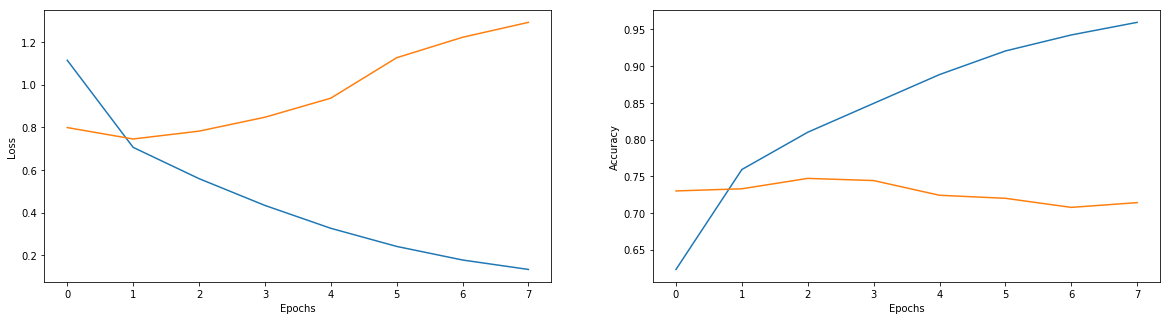

In [34]:
from matplotlib import pyplot as plt #plt is a visualization module in matplotlib.  
%matplotlib inline 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc)
plt.plot(val_acc)

In [31]:
final =  model.predict_classes(x_test_msg)
result = pd.DataFrame({'id': dataframe_test['id'], 'target': final})
result['hate_speech'] = result.apply(lambda row: 1 if row['target'] in [4,5,6,7] else 0, axis=1 )
result['obscene'] = result.apply(lambda row: 1 if row['target'] in [2,3,5,7] else 0, axis=1 )
result['insulting'] = result.apply(lambda row: 1 if row['target'] in [1,3,6,7] else 0, axis=1 )
result = result.drop('target', axis = 1)
result.head()

,id,hate_speech,obscene,insulting
0,21810,0,0,0
1,5865,0,0,0
2,25859,0,0,0
3,8721,1,1,1
4,8194,0,0,0


In [32]:
result.to_csv("result5.csv", index=False)

In [35]:
MAX_SEQUENCE_LENGTH = 200

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print(x_train)
x_test_msg = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

Shape of data tensor: (25307, 200)
[[    0     0     0 ...   556    14   104]
 [    0     0     0 ...     1  4915  7241]
 [    0     0     0 ...  9885  1437  1775]
 ...
 [    0     0     0 ...     6   203   128]
 [    0     0     0 ...   188 11200    79]
 [    0     0     0 ...     0  1018   296]]


In [36]:
X = x_train
Y = dataframe['target']
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(Y)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size=0.33, random_state=seed)

In [41]:
max_features = 20000
emb_size = 128
maxlen = 200
model = Sequential()
model.add(Embedding(max_features,emb_size,input_length =maxlen ))
model.add(Conv1D(128, 5, activation='relu',use_bias=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
nb_epochs = 8
# training the MLP model
history_200 = model.fit(X_train, Y_train, epochs=nb_epochs, batch_size=128, validation_split=0.1) 

Train on 15259 samples, validate on 1696 samples
Epoch 1/8
15259/15259 [==============================] - 59s 4ms/step - loss: 1.4157 - acc: 0.5216 - val_loss: 0.9161 - val_acc: 0.6893
Epoch 2/8
15259/15259 [==============================] - 58s 4ms/step - loss: 0.8265 - acc: 0.7188 - val_loss: 0.7662 - val_acc: 0.7347
Epoch 3/8
15259/15259 [==============================] - 59s 4ms/step - loss: 0.6507 - acc: 0.7803 - val_loss: 0.7746 - val_acc: 0.7317
Epoch 4/8
15259/15259 [==============================] - 60s 4ms/step - loss: 0.5386 - acc: 0.8184 - val_loss: 0.8710 - val_acc: 0.7300
Epoch 5/8
15259/15259 [==============================] - 62s 4ms/step - loss: 0.4527 - acc: 0.8415 - val_loss: 0.9313 - val_acc: 0.7305
Epoch 6/8
15259/15259 [==============================] - 56s 4ms/step - loss: 0.3832 - acc: 0.8559 - val_loss: 0.9736 - val_acc: 0.7217
Epoch 7/8
15259/15259 [==============================] - 57s 4ms/step - loss: 0.3160 - acc: 0.8788 - val_loss: 1.1484 - val_acc: 0.7158

In [43]:
hamming_score_step(model.predict_classes(X_test), Y_test.argmax(1))

Hamming score: 0.7933030012771393


In [44]:
train_acc_200 = history_200.history['acc']
train_loss_200 = history_200.history['loss']

val_acc_200 = history_200.history['val_acc']
val_loss_200 = history_200.history['val_loss']

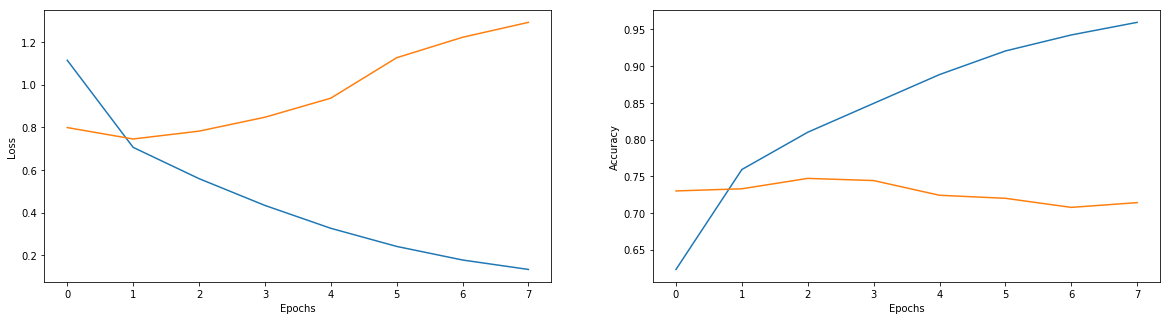

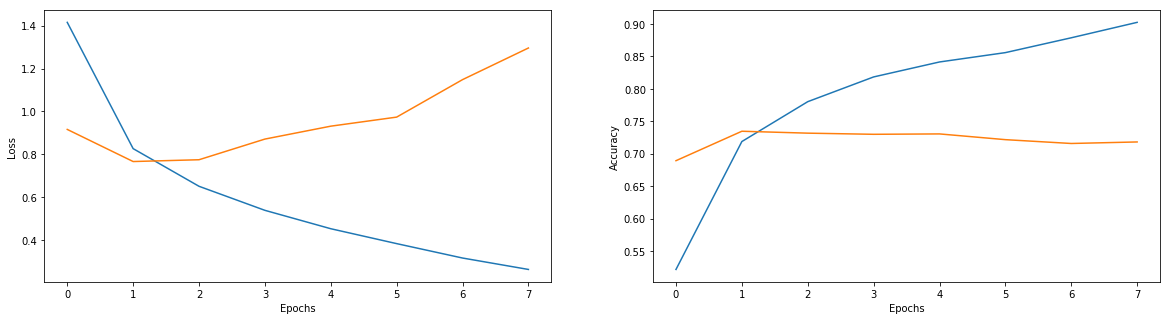

In [45]:
from matplotlib import pyplot as plt #plt is a visualization module in matplotlib.  
%matplotlib inline 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc)
plt.plot(val_acc)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_200)
plt.plot(val_loss_200)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_200)
plt.plot(val_acc_200)

In [46]:
final =  model.predict_classes(x_test_msg)
result = pd.DataFrame({'id': dataframe_test['id'], 'target': final})
result['hate_speech'] = result.apply(lambda row: 1 if row['target'] in [4,5,6,7] else 0, axis=1 )
result['obscene'] = result.apply(lambda row: 1 if row['target'] in [2,3,5,7] else 0, axis=1 )
result['insulting'] = result.apply(lambda row: 1 if row['target'] in [1,3,6,7] else 0, axis=1 )
result = result.drop('target', axis = 1)
result.to_csv("result6.csv", index=False)
result.head()

,id,hate_speech,obscene,insulting
0,21810,0,0,0
1,5865,0,0,0
2,25859,0,0,0
3,8721,1,1,1
4,8194,0,0,0


In [48]:
max_features = 20000
emb_size = 128
maxlen = 200
model = Sequential()
model.add(Embedding(max_features,emb_size,input_length =maxlen ))
model.add(Conv1D(128, 5, activation='relu',use_bias=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.3))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
nb_epochs = 8
history_201 = model.fit(X_train, Y_train, epochs=nb_epochs, batch_size=128, validation_split=0.1)

Train on 15259 samples, validate on 1696 samples
Epoch 1/8
15259/15259 [==============================] - 57s 4ms/step - loss: 1.4681 - acc: 0.5055 - val_loss: 0.9791 - val_acc: 0.6509
Epoch 2/8
15259/15259 [==============================] - 55s 4ms/step - loss: 0.8969 - acc: 0.6941 - val_loss: 0.7718 - val_acc: 0.7447
Epoch 3/8
15259/15259 [==============================] - 59s 4ms/step - loss: 0.7186 - acc: 0.7614 - val_loss: 0.7894 - val_acc: 0.7364
Epoch 4/8
15259/15259 [==============================] - 59s 4ms/step - loss: 0.6204 - acc: 0.7947 - val_loss: 0.8102 - val_acc: 0.7323
Epoch 5/8
15259/15259 [==============================] - 61s 4ms/step - loss: 0.5499 - acc: 0.8166 - val_loss: 0.8702 - val_acc: 0.7270
Epoch 6/8
15259/15259 [==============================] - 59s 4ms/step - loss: 0.4697 - acc: 0.8360 - val_loss: 0.9344 - val_acc: 0.7087
Epoch 7/8
15259/15259 [==============================] - 56s 4ms/step - loss: 0.4149 - acc: 0.8484 - val_loss: 0.9994 - val_acc: 0.7152

In [49]:
hamming_score_step(model.predict_classes(X_test), Y_test.argmax(1))

Hamming score: 0.7919061302681991


In [50]:
train_acc_201 = history_201.history['acc']
train_loss_201 = history_201.history['loss']

val_acc_201 = history_201.history['val_acc']
val_loss_201 = history_201.history['val_loss']


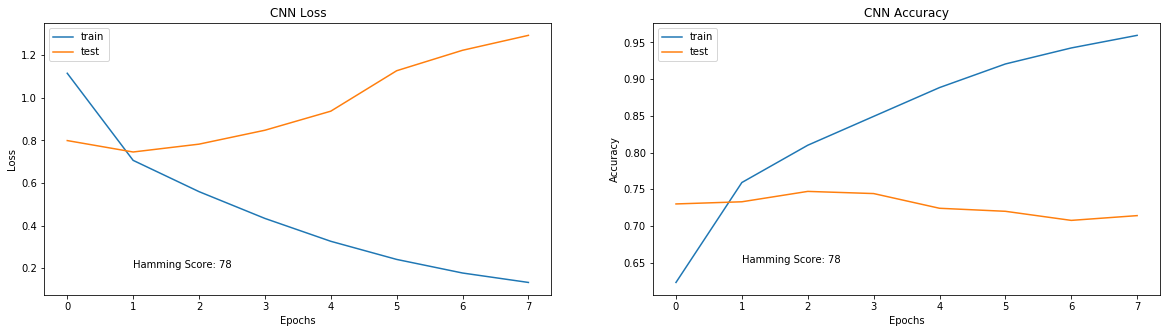

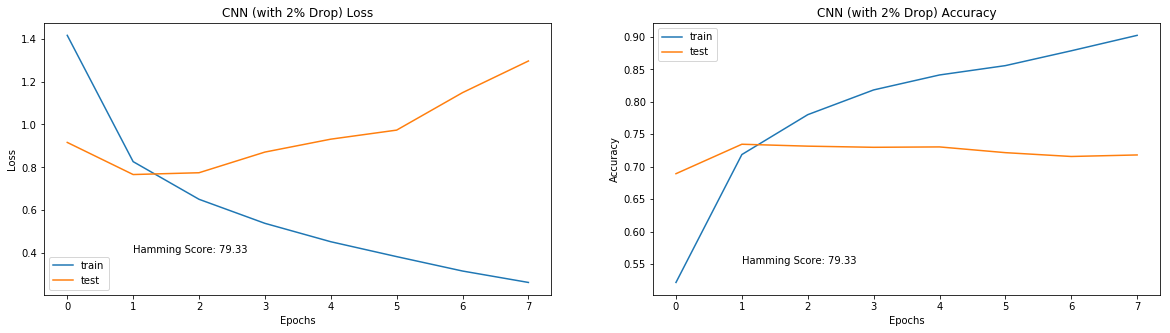

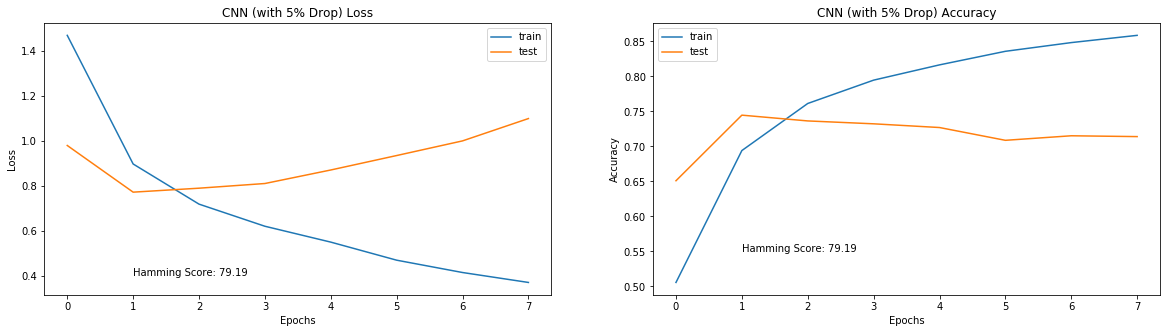

In [80]:
from matplotlib import pyplot as plt #plt is a visualization module in matplotlib.  
%matplotlib inline 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="test")
plt.legend()
plt.annotate("Hamming Score: 78",xy=(1, .2))
plt.title('CNN Loss')


plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc,  label="train")
plt.plot(val_acc, label="test")
plt.legend()
plt.annotate("Hamming Score: 78",xy=(1, .65))
plt.title('CNN Accuracy')

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_200,  label="train")
plt.plot(val_loss_200, label="test")
plt.legend()
plt.annotate("Hamming Score: 79.33",xy=(1, .4))
plt.title('CNN (with 2% Drop) Loss')

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_200,  label="train")
plt.plot(val_acc_200, label="test")
plt.legend()
plt.annotate("Hamming Score: 79.33",xy=(1, .55))
plt.title('CNN (with 2% Drop) Accuracy')

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_201,label="train")
plt.plot(val_loss_201,label="test")
plt.legend()
plt.annotate("Hamming Score: 79.19",xy=(1, .4))
plt.title('CNN (with 5% Drop) Loss')

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_201,  label="train")
plt.plot(val_acc_201, label="test")
plt.legend()
plt.annotate("Hamming Score: 79.19",xy=(1, .55))
plt.title('CNN (with 5% Drop) Accuracy')


plt.savefig('CNN.png')

In [64]:
final =  model.predict_classes(x_test_msg)
result = pd.DataFrame({'id': dataframe_test['id'], 'target': final})
result['hate_speech'] = result.apply(lambda row: 1 if row['target'] in [4,5,6,7] else 0, axis=1 )
result['obscene'] = result.apply(lambda row: 1 if row['target'] in [2,3,5,7] else 0, axis=1 )
result['insulting'] = result.apply(lambda row: 1 if row['target'] in [1,3,6,7] else 0, axis=1 )
result = result.drop('target', axis = 1)
result.to_csv("result7.csv", index=False)
result.head()

,id,hate_speech,obscene,insulting
0,21810,0,0,0
1,5865,0,0,0
2,25859,0,0,0
3,8721,1,1,1
4,8194,0,0,0
